In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing/ab_testing.xlsx


In [2]:

import scipy as sp
from statsmodels.stats.proportion import proportions_ztest
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import \
    ttest_1samp, \
    shapiro, \
    levene, \
    ttest_ind, \
    mannwhitneyu, \
    pearsonr, \
    spearmanr, \
    kendalltau, \
    f_oneway, \
    kruskal

# AB Testing

**What is A/B Testing?**

*  (also known as split testing or bucket testing)  is a randomized experimentation process 
* A/B testing is a way to compare two versions of something to figure out which performs better. 
* In A/B testing, A refers to ‘control’ or the original testing variable. Whereas B refers to ‘variation’ or a new version of the original testing variable. 


In [3]:
!pip install openpyxl
data_control = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name="Control Group")
data_test = pd.read_excel("../input/ab-testing/ab_testing.xlsx", sheet_name="Test Group")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 1.1 MB/s eta 0:00:00


* Impression – Ad views
* Click – Click
* Indicates the number of clicks on the displayed ad.
* Variables
* Purchase – Purchase
* Indicates the number of products purchased after the ads clicked.
* Earning – Earning
* Boiler obtained after purchased products

In [4]:
data_control.head()

,Impression,Click,Purchase,Earning
0,82529.459271,6090.077317,665.211255,2311.277143
1,98050.451926,3382.861786,315.084895,1742.806855
2,82696.023549,4167.965750,458.083738,1797.827447
3,109914.400398,4910.882240,487.090773,1696.229178
4,108457.762630,5987.655811,441.034050,1543.720179


In [5]:
data_test.head()

,Impression,Click,Purchase,Earning
0,120103.503796,3216.547958,702.160346,1939.611243
1,134775.943363,3635.082422,834.054286,2929.405820
2,107806.620788,3057.143560,422.934258,2526.244877
3,116445.275526,4650.473911,429.033535,2281.428574
4,145082.516838,5201.387724,749.860442,2781.697521


## Test normality assumption

In [6]:
data_control.groupby("Click")['Purchase'].mean() #Before
data_test.groupby("Click")['Purchase'].mean() #The next tried method also increased, but did it increase by chance?
data_control["Purchase"].mean() #550.894058
data_test["Purchase"].mean() #582.106096 an increase is observed

582.1060966484677

In [7]:
#does the test data follows normal distribution?
#H0: follows noraml / H1: not follows
test_stat, pvalue = sp.stats.shapiro(data_test['Purchase'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

# H0 cannot be denied

Test Stat = 0.9589, p-value = 0.1541


In [8]:

test_stat, pvalue = sp.stats.shapiro(data_control['Purchase'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

# H0 cannot be denied

Test Stat = 0.9773, p-value = 0.5891


## Test variance homogenous

In [9]:
#H0: Variances are Homogeneous / H1: Variances are not  Homogeneous
test_stat, pvalue = sp.stats.levene(data_control["Purchase"],data_test["Purchase"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))
# H0 cannot be denied
# Variances are also homogeneous
# Independent two-sample t-test (parametric test) if assumptions are met

Test Stat = 2.6393, p-value = 0.1083


In [10]:
test_stat, pvalue = sp.stats.ttest_ind(data_control["Purchase"],data_test["Purchase"],
                              equal_var=True)
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

# H0 cannot be denied
# There is no statistically significant difference of the mean between the two.

Test Stat = -0.9416, p-value = 0.3493


In [11]:
#recommend maximum bidding as there is no statistically significant difference between them
data_control.groupby("Impression")['Purchase'].mean().sum() #Before 22035.762350
data_test.groupby("Impression")['Purchase'].mean().sum() #After 23284.243865

test_stat, pvalue = shapiro(data_control.groupby("Impression")['Purchase'].mean())
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

test_stat, pvalue = shapiro(data_test.groupby("Impression")['Purchase'].mean())
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.9773, p-value = 0.5891
Test Stat = 0.9589, p-value = 0.1541


## Test for individual feature

In [12]:
def pvalue_plot(col, equal_var = True):
    pvalue_plot_list = []
    for i in range(1, len(data_control[col].values)):
        test_stat, pvalue = sp.stats.ttest_ind(data_control.loc[:i, col], data_test.loc[:i, col], equal_var=equal_var)
        pvalue_plot_list.append(pvalue)
    plt.plot(pvalue_plot_list)
    plt.ylabel("P-Value")
    plt.xlabel("Count")
    plt.show()

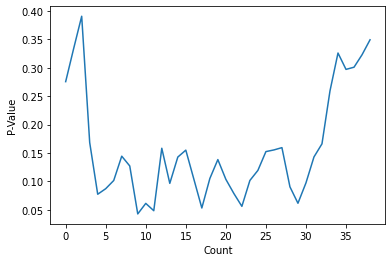

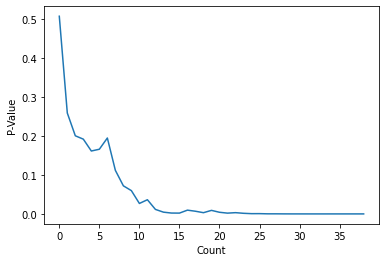

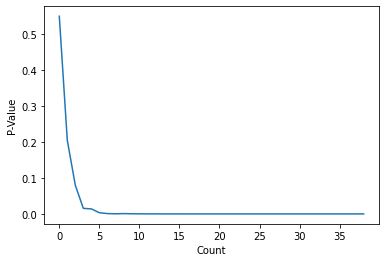

In [13]:
#constanctly cannot reject H0
pvalue_plot(col="Purchase", equal_var=True)
#reject H0 from around 12-15
pvalue_plot(col="Click", equal_var=False)
pvalue_plot(col="Earning", equal_var=True)

# Test
**Normality assumption**

 
* **Visualization**: histogram, QQ-plot

* **Statistical tests:**

D'Agostino-Pearson, Anderson-Darling, Shapiro-Wilk and Kolmogorov-Smirnov. Each of the tests produces a p-value that tests the null hypothesis that the values (the sample) were sampled from a Normal (Gaussian) distribution (or population). 
* the Anderson-Darling test is for completely specified distributions, while the Shapiro-Wilk is for normals with any mean and variance.
* Anderson-Darling test is much more sensitive to the tails of distribution, whereas Kolmogorov-Smirnov test is more aware of the center of distribution. 
* If data tends to have individual outliers, the Ryan-Joiner test is the most appropriate.

**Variance homogeneity**
* f-test: Test for the equality of the two population variances. If a researcher wants to test whether or not two independent samples have been drawn from a normal population with the same variability, then he generally employs the F-test.
* Levene's test (levene):  Inferential statistic used to assess the equality of variances for a variable calculated for two or more groups

Note: The above two tests are commonly used to check for homogeneity of variance: Fisher's F test and Levene's test. Fisher's F test, which is introduced here, is restricted to comparison of two variances/groups while Levene's test can assess more than two variances/groups.

* t-test(ttest_ind): This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. A t-test can only be used when comparing the means of two groups 

**Reference**


* [https://vwo.com/ab-testing/](http://)
* https://blog.hubspot.com/marketing/how-to-do-a-b-testing